# Import Required Libraries and Read Data

In [2]:
import pandas as pd
%pip install numpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind

# Load data
transaction_data = pd.read_csv("QVI_transaction_data.csv")
customer_data = pd.read_csv("QVI_purchase_behaviour.csv")

# Exploratory Data Analysis

In [3]:
print("Transaction Data Structure:")
display(transaction_data.info())
display(transaction_data.head(10))

# Convert DATE column
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')

Transaction Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202561 entries, 0 to 202560
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            202561 non-null  int64  
 1   STORE_NBR       202561 non-null  int64  
 2   LYLTY_CARD_NBR  202561 non-null  int64  
 3   TXN_ID          202561 non-null  int64  
 4   PROD_NBR        202561 non-null  int64  
 5   PROD_NAME       202561 non-null  object 
 6   PROD_QTY        202560 non-null  float64
 7   TOT_SALES       202560 non-null  float64
dtypes: float64(2), int64(5), object(1)
memory usage: 12.4+ MB


None

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2.0,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3.0,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2.0,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5.0,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3.0,13.8
5,43604,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1.0,5.1
6,43601,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1.0,5.7
7,43601,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1.0,3.6
8,43332,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1.0,3.9
9,43330,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2.0,7.2


# Product Analysis

In [4]:
# Extract unique words from PROD_NAME
product_words = pd.Series(" ".join(transaction_data['PROD_NAME'].unique()).split())
product_words = product_words[product_words.str.match("^[A-Za-z]+$")]

# Count frequency
word_counts = product_words.value_counts().reset_index()
word_counts.columns = ['words', 'count']
print(word_counts.head(10))

# Remove salsa products
transaction_data = transaction_data[~transaction_data['PROD_NAME'].str.lower().str.contains("salsa")]


      words  count
0     Chips     21
1    Smiths     16
2       Cut     14
3   Crinkle     14
4    Kettle     13
5      Salt     12
6    Cheese     12
7  Original     10
8     Salsa      9
9   Doritos      9


# Handle Outlier

In [6]:
# Identify outlier
outlier_customer = transaction_data[transaction_data['PROD_QTY'] == 200]['LYLTY_CARD_NBR'].unique()
transaction_data = transaction_data[~transaction_data['LYLTY_CARD_NBR'].isin(outlier_customer)]


# Transactions Over Time

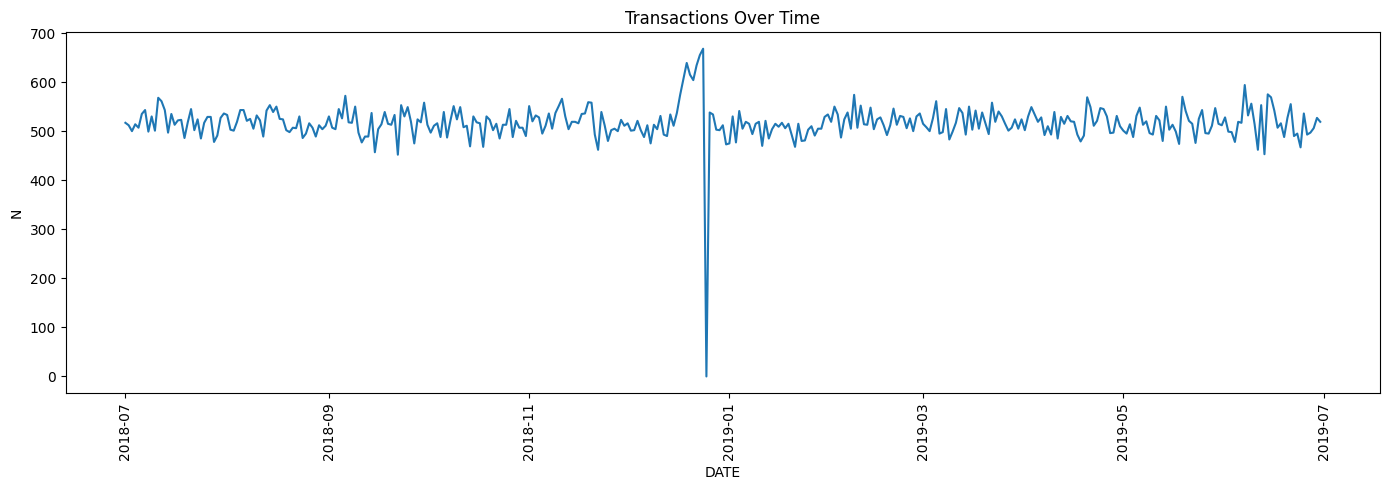

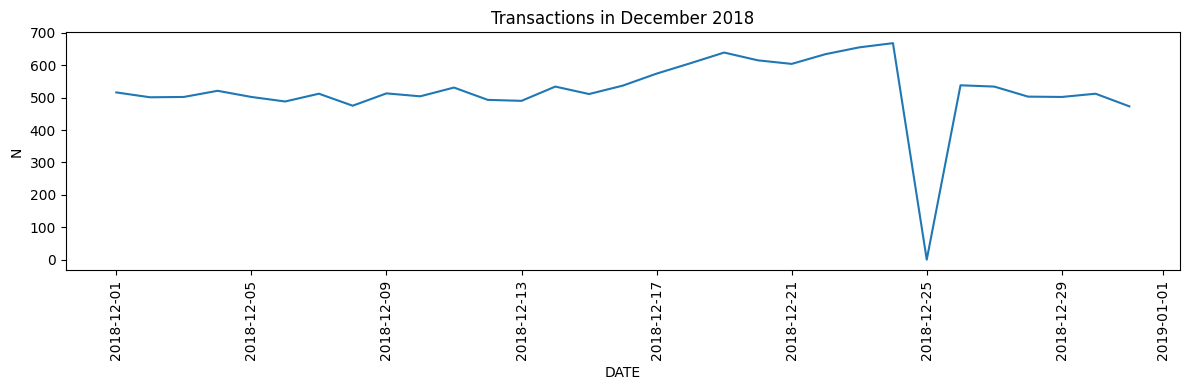

In [7]:
daily_transactions = transaction_data.groupby('DATE').size().reset_index(name='N')

# Fill missing dates
date_sequence = pd.date_range(start="2018-07-01", end="2019-06-30")
transaction_count_full = pd.DataFrame({'DATE': date_sequence})
transaction_count_full = transaction_count_full.merge(daily_transactions, on='DATE', how='left').fillna(0)

# Plot transactions over time
plt.figure(figsize=(14, 5))
sns.lineplot(data=transaction_count_full, x='DATE', y='N')
plt.title('Transactions Over Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# December plot
december_data = transaction_count_full[(transaction_count_full['DATE'] >= "2018-12-01") & (transaction_count_full['DATE'] <= "2018-12-31")]

plt.figure(figsize=(12, 4))
sns.lineplot(data=december_data, x='DATE', y='N')
plt.title('Transactions in December 2018')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Extract Pack Size and Clean Brands

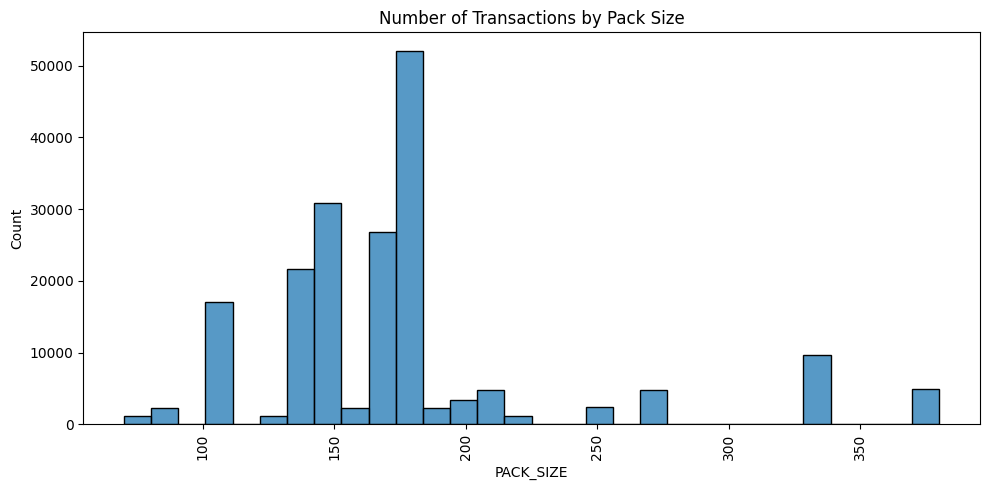

In [8]:
# Extract pack size
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)').astype(float)

# Histogram of PACK_SIZE
plt.figure(figsize=(10, 5))
sns.histplot(data=transaction_data, x='PACK_SIZE', bins=30)
plt.title('Number of Transactions by Pack Size')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Extract brand (first word)
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0].str.upper()

# Clean up brand names
brand_corrections = {
    "RED": "RRD", "SNBTS": "SUNBITES", "INFZNS": "INFUZIONS",
    "WW": "WOOLWORTHS", "SMITH": "SMITHS", "NCC": "NATURAL",
    "DORITO": "DORITOS", "GRAIN": "GRNWVES"
}
transaction_data['BRAND'] = transaction_data['BRAND'].replace(brand_corrections)


# Bar Plot for LIFESTAGE Distribution

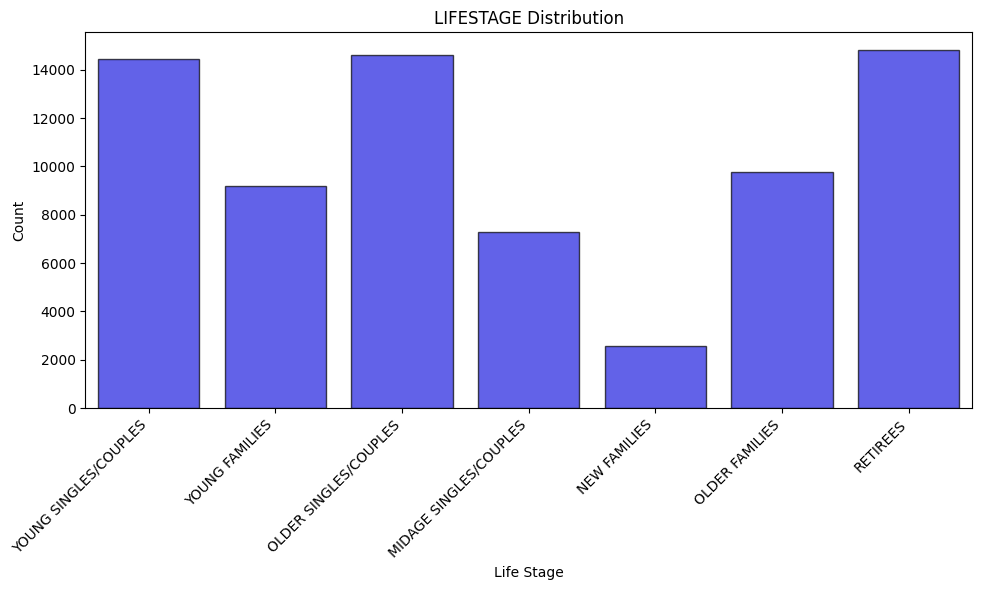

In [9]:
# Set the plot style
plt.figure(figsize=(10, 6))
sns.countplot(data=customer_data, x='LIFESTAGE', color='blue', edgecolor='black', alpha=0.7)

# Customize plot
plt.title('LIFESTAGE Distribution')
plt.xlabel('Life Stage')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()
plt.show()

# Merge and Analyze Customer Data

In [12]:
data = pd.merge(transaction_data, customer_data, on="LYLTY_CARD_NBR", how="left")
missing_customers = data['LYLTY_CARD_NBR'].isna().sum()
print("Missing customer entries:", missing_customers)

# Save merged data
data.to_csv("QVI_data.csv", index=False)


Missing customer entries: 0


# Sales Analysis and Visualization

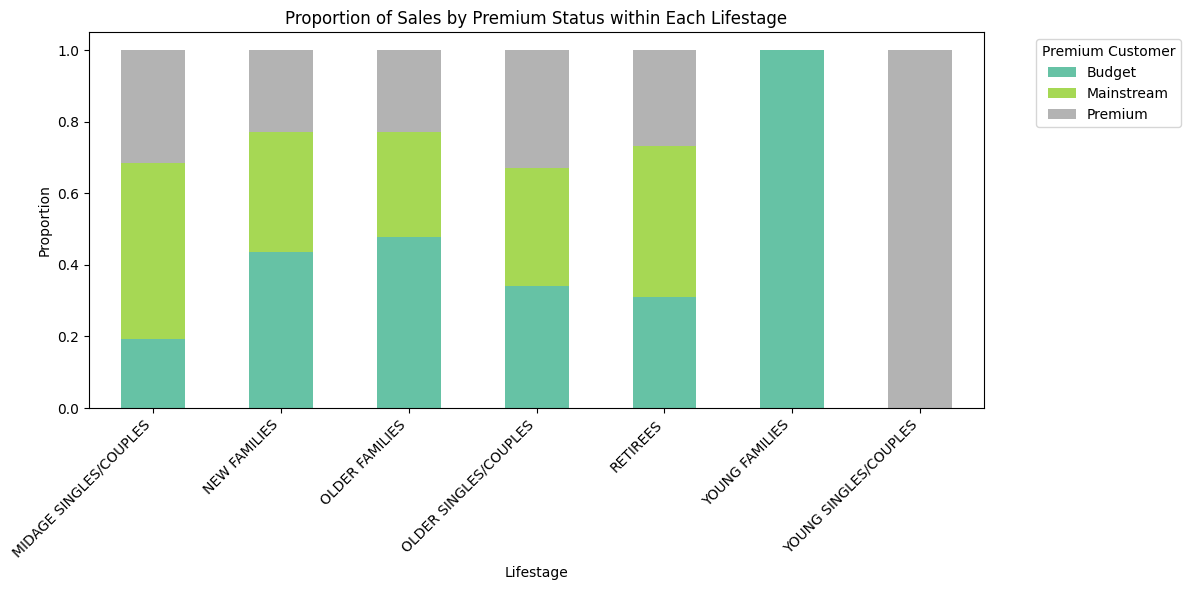

In [13]:
# Total sales by segment
total_sales_by_segment = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Pivot for stacked bar
pivot_data = total_sales_by_segment.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='TOT_SALES')

# Normalize to get proportions
pivot_prop = pivot_data.div(pivot_data.sum(axis=1), axis=0)

# Plot
pivot_prop.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

plt.title('Proportion of Sales by Premium Status within Each Lifestage')
plt.ylabel('Proportion')
plt.xlabel('Lifestage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Premium Customer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Count of Customers by LIFESTAGE and PREMIUM_CUSTOMER

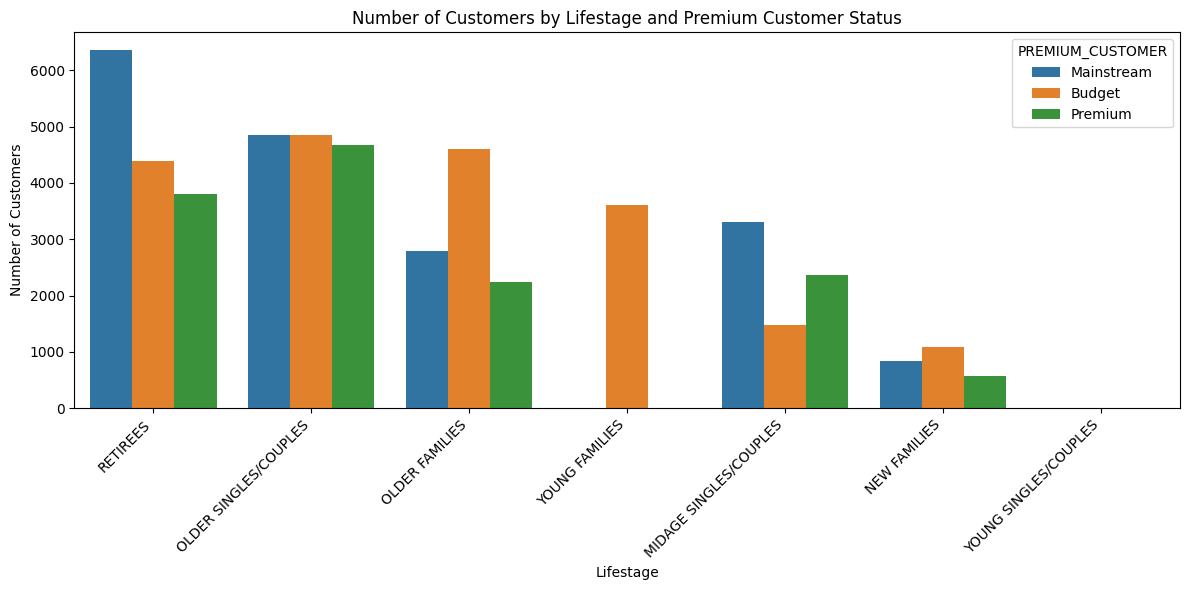

In [14]:
# Count unique customers
customer_count_by_segment = (
    data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR']
    .nunique()
    .reset_index(name='CUSTOMERS')
    .sort_values(by='CUSTOMERS', ascending=False)
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=customer_count_by_segment, x='LIFESTAGE', y='CUSTOMERS', hue='PREMIUM_CUSTOMER')
plt.title('Number of Customers by Lifestage and Premium Customer Status')
plt.xlabel('Lifestage')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Average Number of Units per Customer

<ipython-input-15-894e83c16097>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['PROD_QTY'].sum() / x['LYLTY_CARD_NBR'].nunique())


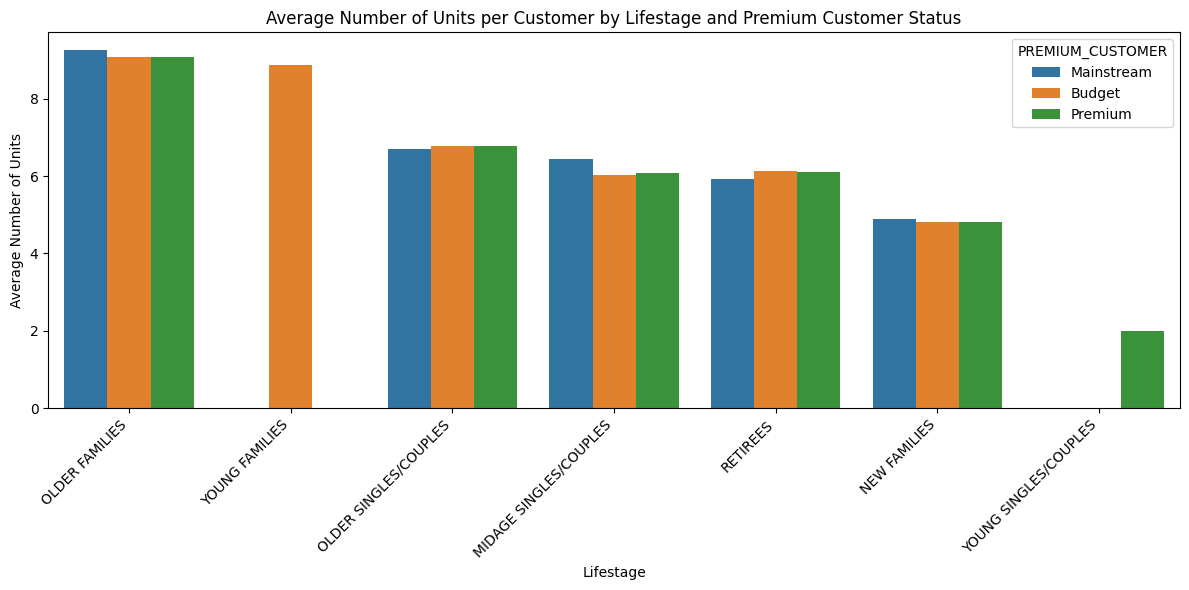

In [15]:
avg_units_per_customer = (
    data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .apply(lambda x: x['PROD_QTY'].sum() / x['LYLTY_CARD_NBR'].nunique())
    .reset_index(name='AVG')
    .sort_values(by='AVG', ascending=False)
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_units_per_customer, x='LIFESTAGE', y='AVG', hue='PREMIUM_CUSTOMER')
plt.title('Average Number of Units per Customer by Lifestage and Premium Customer Status')
plt.xlabel('Lifestage')
plt.ylabel('Average Number of Units')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Average Price per Unit

<ipython-input-16-303bf3fdc5ef>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['TOT_SALES'].sum() / x['PROD_QTY'].sum())


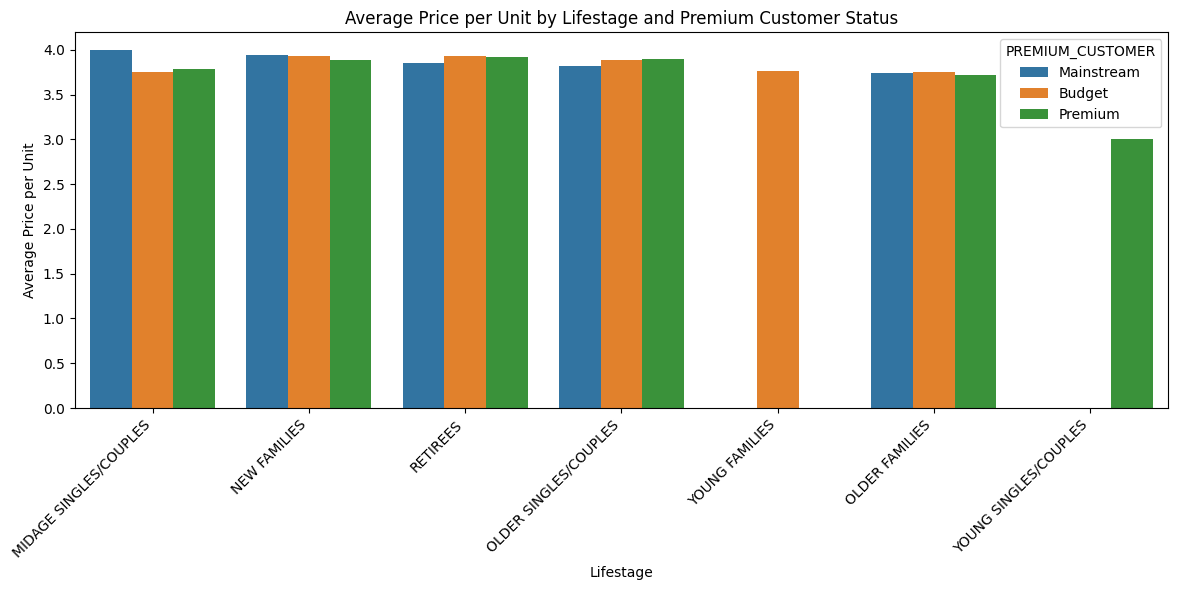

In [16]:
avg_price_per_unit = (
    data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .apply(lambda x: x['TOT_SALES'].sum() / x['PROD_QTY'].sum())
    .reset_index(name='AVG')
    .sort_values(by='AVG', ascending=False)
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_price_per_unit, x='LIFESTAGE', y='AVG', hue='PREMIUM_CUSTOMER')
plt.title('Average Price per Unit by Lifestage and Premium Customer Status')
plt.xlabel('Lifestage')
plt.ylabel('Average Price per Unit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Perform Independent t-test

In [17]:
# Add price per unit column
data['price'] = data['TOT_SALES'] / data['PROD_QTY']

# Filter target groups
mainstream_group = data[
    (data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) &
    (data['PREMIUM_CUSTOMER'] == 'Mainstream')
]['price']

non_mainstream_group = data[
    (data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) &
    (data['PREMIUM_CUSTOMER'] != 'Mainstream')
]['price']

# Perform one-tailed t-test
t_stat, p_value = ttest_ind(mainstream_group, non_mainstream_group, alternative='greater')

# Print full precision
print("T-test result:")
print("t-statistic =", t_stat)
print("p-value =", p_value)


T-test result:
t-statistic = 16.81992329999356
p-value = 2.0489501860316487e-63


# Deep Dive into Mainstream Young Singles/Couples

In [18]:
segment1 = data[
    (data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (data['PREMIUM_CUSTOMER'] == 'Mainstream')
]

other = data[~((data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
               (data['PREMIUM_CUSTOMER'] == 'Mainstream'))]


# Brand Affinity Analysis

In [19]:
# Total quantity
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Share by brand
quantity_segment1_by_brand = segment1.groupby('BRAND')['PROD_QTY'].sum().reset_index()
quantity_segment1_by_brand['targetSegment'] = quantity_segment1_by_brand['PROD_QTY'] / quantity_segment1
quantity_segment1_by_brand.drop('PROD_QTY', axis=1, inplace=True)

quantity_other_by_brand = other.groupby('BRAND')['PROD_QTY'].sum().reset_index()
quantity_other_by_brand['other'] = quantity_other_by_brand['PROD_QTY'] / quantity_other
quantity_other_by_brand.drop('PROD_QTY', axis=1, inplace=True)

# Merge and compute affinity
brand_proportions = pd.merge(quantity_segment1_by_brand, quantity_other_by_brand, on='BRAND')
brand_proportions['affinityToBrand'] = brand_proportions['targetSegment'] / brand_proportions['other']
brand_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

print(brand_proportions[['BRAND', 'targetSegment', 'other', 'affinityToBrand']])


Empty DataFrame
Columns: [BRAND, targetSegment, other, affinityToBrand]
Index: []


# Pack Size Affinity Analysis

In [20]:
# Share by pack size
quantity_segment1_by_pack = segment1.groupby('PACK_SIZE')['PROD_QTY'].sum().reset_index()
quantity_segment1_by_pack['targetSegment'] = quantity_segment1_by_pack['PROD_QTY'] / quantity_segment1
quantity_segment1_by_pack.drop('PROD_QTY', axis=1, inplace=True)

quantity_other_by_pack = other.groupby('PACK_SIZE')['PROD_QTY'].sum().reset_index()
quantity_other_by_pack['other'] = quantity_other_by_pack['PROD_QTY'] / quantity_other
quantity_other_by_pack.drop('PROD_QTY', axis=1, inplace=True)

# Merge and compute affinity
pack_proportions = pd.merge(quantity_segment1_by_pack, quantity_other_by_pack, on='PACK_SIZE')
pack_proportions['affinityToPack'] = pack_proportions['targetSegment'] / pack_proportions['other']
pack_proportions = pack_proportions.sort_values(by='affinityToPack', ascending=False)

print(pack_proportions[['PACK_SIZE', 'targetSegment', 'other', 'affinityToPack']])


Empty DataFrame
Columns: [PACK_SIZE, targetSegment, other, affinityToPack]
Index: []


# Conclusion

High sales volumes were driven by Budget older families, Mainstream young singles/couples, and Mainstream retirees.

Young singles/couples and mid-age groups are more likely to buy higher-priced or impulse chips.

Tyrrells and Twisties are more favored among young singles/couples.